In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
from scipy import sparse
import pickle
import os


In [15]:
PATH = os.getcwd()
PATH


'/Users/pleng/python/mlps/Project/01_00_Data_cleaning_&_EDA_train/STAR_model'

In [16]:
# Load the data from 01_Data_Cleaning output
df_train = pd.read_pickle(PATH + "/cleaned_train_dataset.pkl")
df_valid = pd.read_pickle(PATH + "/cleaned_validation_dataset.pkl")

# NEW: Load the test dataset from CSV
df_test = pd.read_pickle(PATH + "/cleaned_test_data.pkl")
print(f"Test data shape: {df_test.shape}")

# Display test data information
df_test.info()


Test data shape: (2805, 27)
<class 'pandas.core.frame.DataFrame'>
Index: 2805 entries, 12 to 4065
Data columns (total 27 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   time_value                            2805 non-null   datetime64[ns]
 1   geo_value                             2805 non-null   object        
 2   smoothed_wspent_time_1d               2805 non-null   float64       
 3   smoothed_wtested_14d                  2805 non-null   float64       
 4   smoothed_wpublic_transit_1d           2805 non-null   float64       
 5   smoothed_wcovid_vaccinated_or_accept  2805 non-null   float64       
 6   smoothed_wworried_become_ill          2805 non-null   float64       
 7   smoothed_wvaccine_likely_govt_health  2805 non-null   float64       
 8   smoothed_wshop_1d                     2805 non-null   float64       
 9   smoothed_wwork_outside_home_1d        2805 non-nul

In [17]:
# Combine datasets and sort
df_combined = pd.concat([df_train, df_valid], axis=0)
df_combined = df_combined.sort_values(by=['geo_value', 'time_value'])
print(f"Combined data shape: {df_combined.shape}")


Combined data shape: (14153, 27)


In [18]:
target_variable = 'smoothed_wcovid_vaccinated'


In [19]:
# Function to create spatial weight matrix based on geographic proximity
def create_spatial_weights(df):
    """
    Create a spatial weights matrix based on geographic coordinates
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with geo_value
        
    Returns:
    --------
    scipy.sparse.csr_matrix
        Spatial weights matrix (row-normalized)
    dict
        Mapping of geo_value to matrix index
    """
    # Get unique geo values
    geo_values = df['geo_value'].unique()
    n_regions = len(geo_values)
    
    # Create mapping of geo_value to matrix index
    geo_to_idx = {geo: idx for idx, geo in enumerate(geo_values)}
    
    # Get state for each geo_value
    geo_state = df[['geo_value', 'state']].drop_duplicates().set_index('geo_value')['state']
        
    # Create adjacency based on same state
    W = np.zeros((n_regions, n_regions))
    for i, geo_i in enumerate(geo_values):
        state_i = geo_state.get(geo_i, "")
        for j, geo_j in enumerate(geo_values):
            if i != j:
                state_j = geo_state.get(geo_j, "")
                if state_i == state_j and state_i != "":
                    W[i, j] = 1
    
    # Row-normalize weights
    row_sums = W.sum(axis=1)
    row_sums[row_sums == 0] = 1  # Avoid division by zero
    W_normalized = W / row_sums[:, np.newaxis]
    
    # Convert to sparse matrix for efficiency
    W_sparse = sparse.csr_matrix(W_normalized)
    
    return W_sparse, geo_to_idx


In [20]:
# Create spatial weights matrix
W, geo_to_idx = create_spatial_weights(df_combined)


In [21]:
# Function to implement spatial lag for a given date
def spatial_lag(df, date, variable, W, geo_to_idx):
    """
    Calculate spatial lag for a given variable at a specific date
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with data
    date : datetime
        Date for which to calculate spatial lag
    variable : str
        Variable for which to calculate spatial lag
    W : scipy.sparse.csr_matrix
        Spatial weights matrix
    geo_to_idx : dict
        Mapping of geo_value to matrix index
        
    Returns:
    --------
    pd.Series
        Spatial lag values indexed by geo_value
    """
    # Get data for the specific date
    date_data = df[df['time_value'] == date]
    
    # Create a vector of values in the order expected by W
    n_regions = len(geo_to_idx)
    x = np.zeros(n_regions)
    
    for idx, row in date_data.iterrows():
        geo = row['geo_value']
        if geo in geo_to_idx:
            x[geo_to_idx[geo]] = row[variable]
    
    # Calculate spatial lag: W * x
    lag = W.dot(x)
    
    # Convert back to Series with geo_value index
    lag_series = pd.Series(index=geo_to_idx.keys(), data=[lag[geo_to_idx[geo]] for geo in geo_to_idx.keys()])
    
    return lag_series


In [22]:
def create_spatiotemporal_features(df, feature_list, W, geo_to_idx):
    """
    Create spatial and temporal lag features for multiple variables
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with time_value, geo_value, and features
    feature_list : list
        List of feature names to create spatiotemporal features for
    W : scipy.sparse.csr_matrix
        Spatial weights matrix
    geo_to_idx : dict
        Mapping of geo_value to matrix index
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with added spatiotemporal features
    """
    df_st = df.copy()
    
    print(f"Creating spatiotemporal features for: {feature_list}")
    
    # Create temporal lags n days for each feature
    for feature in feature_list:
        for lag in [1, 2, 7]:
            df_st[f'{feature}_t{lag}'] = df_st.groupby('geo_value')[feature].shift(lag)
    
    # Create spatial lags for each feature and date
    all_dates = sorted(df['time_value'].unique())
    
    for feature in feature_list:
        print(f"Creating spatial lags for {feature}...")
        spatial_lags = {}
        
        for date in all_dates:
            spatial_lags[date] = spatial_lag(df, date, feature, W, geo_to_idx)
        
        # Create spatial lag column for this feature
        spatial_lag_col = f'{feature}_spatial_lag'
        df_st[spatial_lag_col] = np.nan
        
        for idx, row in df_st.iterrows():
            date = row['time_value']
            geo = row['geo_value']
            if date in spatial_lags and geo in spatial_lags[date].index:
                df_st.at[idx, spatial_lag_col] = spatial_lags[date][geo]
        
        # Create temporal lag of spatial lag (t-1)
        df_st[f'{feature}_spatial_lag_t1'] = df_st.groupby('geo_value')[spatial_lag_col].shift(1)
        
        # Create spatiotemporal interaction feature (temporal lag * spatial lag)
        df_st[f'{feature}_st_interaction'] = df_st[f'{feature}_t1'] * df_st[f'{feature}_spatial_lag_t1']

        interaction_values = df_st[f'{feature}_st_interaction'].values.reshape(-1, 1)
        
        # Apply scaling
        scaler = StandardScaler()
        scaled_values = scaler.fit_transform(interaction_values)
        
        # Replace with scaled values
        df_st[f'{feature}_st_interaction'] = scaled_values

        # Remove null values
        df_st = df_st.dropna()
    
    return df_st


In [23]:
# Feature list with better evaluation score
feature_list = [
    'smoothed_wcovid_vaccinated',       # Main target variable
    'smoothed_wworried_become_ill',     # Worry about COVID
    'smoothed_wcovid_vaccinated_or_accept',  # Vaccination acceptance
    'smoothed_wwork_outside_home_1d',   # Outside activity
    'smoothed_wcli'                     # COVID-like illness reports
]


In [24]:
# NEW: Convert date columns to datetime for test data if needed
if 'time_value' in df_test.columns and not pd.api.types.is_datetime64_dtype(df_test['time_value']):
    df_test['time_value'] = pd.to_datetime(df_test['time_value'])

# NEW: Ensure test data has all required columns
required_columns = feature_list + ['geo_value', 'time_value', 'state', 'county_name', 'day', 'week_of_month', 
                                  'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']

missing_columns = [col for col in required_columns if col not in df_test.columns]
if missing_columns:
    print(f"WARNING: Test dataset is missing the following columns: {missing_columns}")
    print("These columns need to be present for the model to work correctly.")
    print("Will attempt to create missing columns if possible.")

# Create day of week dummy variables if needed
if 'day_of_week' in df_test.columns and 'monday' not in df_test.columns:
    df_test['monday'] = (df_test['day_of_week'] == 0).astype(int)
    df_test['tuesday'] = (df_test['day_of_week'] == 1).astype(int)
    df_test['wednesday'] = (df_test['day_of_week'] == 2).astype(int)
    df_test['thursday'] = (df_test['day_of_week'] == 3).astype(int)
    df_test['friday'] = (df_test['day_of_week'] == 4).astype(int)
    df_test['saturday'] = (df_test['day_of_week'] == 5).astype(int)
    df_test['sunday'] = (df_test['day_of_week'] == 6).astype(int)


In [25]:
# NEW: Combine all datasets to ensure we have temporal lags for test data
df_all = pd.concat([df_combined, df_test], axis=0)
df_all = df_all.sort_values(by=['geo_value', 'time_value'])
print(f"All data combined shape: {df_all.shape}")

# Create spatiotemporal features for all data including test
df_st_all = create_spatiotemporal_features(df_all, feature_list, W, geo_to_idx)


All data combined shape: (16958, 27)
Creating spatiotemporal features for: ['smoothed_wcovid_vaccinated', 'smoothed_wworried_become_ill', 'smoothed_wcovid_vaccinated_or_accept', 'smoothed_wwork_outside_home_1d', 'smoothed_wcli']
Creating spatial lags for smoothed_wcovid_vaccinated...
Creating spatial lags for smoothed_wworried_become_ill...
Creating spatial lags for smoothed_wcovid_vaccinated_or_accept...
Creating spatial lags for smoothed_wwork_outside_home_1d...
Creating spatial lags for smoothed_wcli...


In [26]:
# Get train, validation, and test periods
train_dates = df_train['time_value'].unique()
val_dates = df_valid['time_value'].unique()
test_dates = df_test['time_value'].unique()

# Split data with spatiotemporal features
df_train_st = df_st_all[df_st_all['time_value'].isin(train_dates)].copy()
df_valid_st = df_st_all[df_st_all['time_value'].isin(val_dates)].copy()
df_test_st = df_st_all[df_st_all['time_value'].isin(test_dates)].copy()

print(f"Train data with spatiotemporal features: {df_train_st.shape}")
print(f"Validation data with spatiotemporal features: {df_valid_st.shape}")
print(f"Test data with spatiotemporal features: {df_test_st.shape}")


Train data with spatiotemporal features: (5138, 57)
Validation data with spatiotemporal features: (3064, 57)
Test data with spatiotemporal features: (2790, 57)


In [27]:
# Get common features for all models
def get_features(df_train):
    """Get common features for all models"""
    # Define base features for model
    features = [
        f'{target_variable}_t1',  # Temporal autoregressive term (t-1)
        f'{target_variable}_t2',  # Temporal autoregressive term (t-2)
        f'{target_variable}_t7',  # Weekly effect
        f'{target_variable}_spatial_lag_t1',         # Spatial lag
        f'{target_variable}_st_interaction',          # Spatiotemporal interaction
        'day',
        'week_of_month',
        'tuesday',
        'wednesday',
        'thursday',
        'friday',
        'saturday',
        'sunday'
    ]
    
    # Exclude metadata columns and the target variable itself
    excluded_cols = ['time_value', 'geo_value', target_variable, 'day_of_week', 'state', 'county_name']
    
    # Get potential additional predictors
    additional_features = [col for col in df_train.columns 
                          if col not in excluded_cols 
                          and not col.startswith(target_variable)
                          and (col.endswith('_t1') or col.endswith('_t2') or col.endswith('_t7') 
                          or col.endswith('lag') or col.endswith('lag_t1') or col.endswith('st_interaction'))]  # Focus on lag variables
    
    # Combine all features
    all_features = features + additional_features
    
    return all_features


In [28]:
# Function to fit OLS spatial-temporal autoregression model
def fit_star_ols(df_train, df_valid, df_test, target_variable):
    """
    Fit OLS Spatial-Temporal AutoRegressive (STAR) model
    
    Parameters:
    -----------
    df_train : pd.DataFrame
        Training data with spatiotemporal features
    df_valid : pd.DataFrame
        Validation data with spatiotemporal features
    df_test : pd.DataFrame
        Test data with spatiotemporal features
    target_variable : str
        Name of the target variable
        
    Returns:
    --------
    statsmodels.regression.linear_model.RegressionResultsWrapper
        Fitted model
    dict
        Model evaluation metrics
    pd.DataFrame
        Test data with predictions
    """
    # Get common features
    features = get_features(df_train)

    # Prepare data for modeling
    X_train = df_train[features]
    y_train = df_train[target_variable]

    # Add constant
    X_train = sm.add_constant(X_train)

    # Fit model
    model = sm.OLS(y_train, X_train).fit()
    print("\nOLS Model Summary:")
    print(model.summary())

    # Make predictions on validation set
    X_valid = df_valid[features]
    X_valid = sm.add_constant(X_valid)

    # Make predictions on test set
    X_test = df_test[features]
    X_test = sm.add_constant(X_test)

    # Ensure X_valid and X_test have the same columns as X_train
    for dataset in [X_valid, X_test]:
        for col in X_train.columns:
            if col not in dataset.columns:
                dataset[col] = 0
        # Align columns
        dataset = dataset[X_train.columns]

    df_valid['ols_prediction'] = model.predict(X_valid)
    df_test['ols_prediction'] = model.predict(X_test)

    # Evaluate model on validation data
    valid_mask = df_valid['ols_prediction'].notna()
    y_true_valid = df_valid.loc[valid_mask, target_variable]
    y_pred_valid = df_valid.loc[valid_mask, 'ols_prediction']

    # Calculate validation metrics
    valid_metrics = {}
    valid_metrics['rmse'] = np.sqrt(mean_squared_error(y_true_valid, y_pred_valid))
    valid_metrics['mae'] = mean_absolute_error(y_true_valid, y_pred_valid)
    valid_metrics['r2'] = r2_score(y_true_valid, y_pred_valid)
    valid_metrics['mape'] = np.mean(np.abs((y_true_valid - y_pred_valid) / (y_true_valid + 0.01))) * 100

    print(f"\nOLS Spatial-Temporal Autoregression Validation Performance:")
    print(f"RMSE: {valid_metrics['rmse']:.4f}")
    print(f"MAE: {valid_metrics['mae']:.4f}")
    print(f"R²: {valid_metrics['r2']:.4f}")
    print(f"MAPE: {valid_metrics['mape']:.2f}%")
    
    # Evaluate model on test data
    test_mask = df_test['ols_prediction'].notna()
    y_true_test = df_test.loc[test_mask, target_variable]
    y_pred_test = df_test.loc[test_mask, 'ols_prediction']

    # Calculate test metrics
    test_metrics = {}
    test_metrics['rmse'] = np.sqrt(mean_squared_error(y_true_test, y_pred_test))
    test_metrics['mae'] = mean_absolute_error(y_true_test, y_pred_test)
    test_metrics['r2'] = r2_score(y_true_test, y_pred_test)
    test_metrics['mape'] = np.mean(np.abs((y_true_test - y_pred_test) / (y_true_test + 0.01))) * 100

    print(f"\nOLS Spatial-Temporal Autoregression Test Performance:")
    print(f"RMSE: {test_metrics['rmse']:.4f}")
    print(f"MAE: {test_metrics['mae']:.4f}")
    print(f"R²: {test_metrics['r2']:.4f}")
    print(f"MAPE: {test_metrics['mape']:.2f}%")
    
    return model, valid_metrics, test_metrics, df_test



In [29]:
# Function to fit Ridge spatial-temporal autoregression model
def fit_star_ridge(df_train, df_valid, df_test, target_variable):
    """
    Fit Ridge Spatial-Temporal AutoRegressive (STAR) model
    
    Parameters:
    -----------
    df_train : pd.DataFrame
        Training data with spatiotemporal features
    df_valid : pd.DataFrame
        Validation data with spatiotemporal features
    df_test : pd.DataFrame
        Test data with spatiotemporal features
    target_variable : str
        Name of the target variable
        
    Returns:
    --------
    sklearn.linear_model.Ridge
        Fitted model
    dict
        Model evaluation metrics
    pd.DataFrame
        Test data with predictions
    """
    # Get common features
    features = get_features(df_train.copy())
    df_valid = df_valid.copy()
    df_test = df_test.copy()
    
    # Prepare data for modeling
    X_train = df_train[features]
    y_train = df_train[target_variable]
    
    # Grid search for optimal alpha
    alphas = np.logspace(-3, 3, 7)  # [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    
    ridge_cv = GridSearchCV(
        Ridge(random_state=42),
        {'alpha': alphas},
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    
    ridge_cv.fit(X_train, y_train)
    
    best_alpha = ridge_cv.best_params_['alpha']
    print(f"\nBest alpha for Ridge regression: {best_alpha}")
    
    # Fit final model with best alpha
    ridge_model = Ridge(alpha=best_alpha, random_state=42)
    ridge_model.fit(X_train, y_train)
    
    # Print coefficients
    coef_df = pd.DataFrame({
        'Feature': features,
        'Coefficient': ridge_model.coef_
    })
    coef_df = coef_df.sort_values('Coefficient', key=abs, ascending=False)
    print("\nRidge Model Coefficients:")
    print(coef_df)
    
    # Make predictions on validation set
    X_valid = df_valid[features]
    df_valid['ridge_prediction'] = ridge_model.predict(X_valid)
    
    # Make predictions on test set
    X_test = df_test[features]
    df_test['ridge_prediction'] = ridge_model.predict(X_test)
    
    # Evaluate model on validation data
    valid_mask = df_valid['ridge_prediction'].notna()
    y_true_valid = df_valid.loc[valid_mask, target_variable]
    y_pred_valid = df_valid.loc[valid_mask, 'ridge_prediction']
    
    # Calculate validation metrics
    valid_metrics = {}
    valid_metrics['rmse'] = np.sqrt(mean_squared_error(y_true_valid, y_pred_valid))
    valid_metrics['mae'] = mean_absolute_error(y_true_valid, y_pred_valid)
    valid_metrics['r2'] = r2_score(y_true_valid, y_pred_valid)
    valid_metrics['mape'] = np.mean(np.abs((y_true_valid - y_pred_valid) / (y_true_valid + 0.01))) * 100
    
    print(f"\nRidge Spatial-Temporal Autoregression Validation Performance:")
    print(f"RMSE: {valid_metrics['rmse']:.4f}")
    print(f"MAE: {valid_metrics['mae']:.4f}")
    print(f"R²: {valid_metrics['r2']:.4f}")
    print(f"MAPE: {valid_metrics['mape']:.2f}%")
    
    # Evaluate model on test data
    test_mask = df_test['ridge_prediction'].notna()
    y_true_test = df_test.loc[test_mask, target_variable]
    y_pred_test = df_test.loc[test_mask, 'ridge_prediction']
    
    # Calculate test metrics
    test_metrics = {}
    test_metrics['rmse'] = np.sqrt(mean_squared_error(y_true_test, y_pred_test))
    test_metrics['mae'] = mean_absolute_error(y_true_test, y_pred_test)
    test_metrics['r2'] = r2_score(y_true_test, y_pred_test)
    test_metrics['mape'] = np.mean(np.abs((y_true_test - y_pred_test) / (y_true_test + 0.01))) * 100
    
    print(f"\nRidge Spatial-Temporal Autoregression Test Performance:")
    print(f"RMSE: {test_metrics['rmse']:.4f}")
    print(f"MAE: {test_metrics['mae']:.4f}")
    print(f"R²: {test_metrics['r2']:.4f}")
    print(f"MAPE: {test_metrics['mape']:.2f}%")
    
    return ridge_model, valid_metrics, test_metrics, df_test, features



In [30]:
# Function to fit Lasso spatial-temporal autoregression model
def fit_star_lasso(df_train, df_valid, df_test, target_variable):
    """
    Fit Lasso Spatial-Temporal AutoRegressive (STAR) model
    
    Parameters:
    -----------
    df_train : pd.DataFrame
        Training data with spatiotemporal features
    df_valid : pd.DataFrame
        Validation data with spatiotemporal features
    df_test : pd.DataFrame
        Test data with spatiotemporal features
    target_variable : str
        Name of the target variable
        
    Returns:
    --------
    sklearn.linear_model.Lasso
        Fitted model
    dict
        Model evaluation metrics
    pd.DataFrame
        Test data with predictions
    """
    # Get common features
    features = get_features(df_train.copy())
    df_valid = df_valid.copy()
    df_test = df_test.copy()
    
    # Prepare data for modeling
    X_train = df_train[features]
    y_train = df_train[target_variable]
    
    # Grid search for optimal alpha
    alphas = np.logspace(-3, 1, 5)  # [0.001, 0.01, 0.1, 1, 10]
    
    lasso_cv = GridSearchCV(
        Lasso(random_state=42, max_iter=10000),
        {'alpha': alphas},
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    
    lasso_cv.fit(X_train, y_train)
    
    best_alpha = lasso_cv.best_params_['alpha']
    print(f"\nBest alpha for Lasso regression: {best_alpha}")
    
    # Fit final model with best alpha
    lasso_model = Lasso(alpha=best_alpha, random_state=42, max_iter=10000)
    lasso_model.fit(X_train, y_train)
    
    # Print coefficients and identify which features were selected
    coef_df = pd.DataFrame({
        'Feature': features,
        'Coefficient': lasso_model.coef_
    })
    
    # Show non-zero coefficients (features selected by Lasso)
    selected_features = coef_df[coef_df['Coefficient'] != 0].sort_values('Coefficient', key=abs, ascending=False)
    print("\nLasso Model Selected Features and Coefficients:")
    print(selected_features)
    print(f"\nNumber of features selected by Lasso: {len(selected_features)}")
    
    # Make predictions on validation set
    X_valid = df_valid[features]
    df_valid['lasso_prediction'] = lasso_model.predict(X_valid)
    
    # Make predictions on test set
    X_test = df_test[features]
    df_test['lasso_prediction'] = lasso_model.predict(X_test)
    
    # Evaluate model on validation data
    valid_mask = df_valid['lasso_prediction'].notna()
    y_true_valid = df_valid.loc[valid_mask, target_variable]
    y_pred_valid = df_valid.loc[valid_mask, 'lasso_prediction']
    
    # Calculate validation metrics
    valid_metrics = {}
    valid_metrics['rmse'] = np.sqrt(mean_squared_error(y_true_valid, y_pred_valid))
    valid_metrics['mae'] = mean_absolute_error(y_true_valid, y_pred_valid)
    valid_metrics['r2'] = r2_score(y_true_valid, y_pred_valid)
    valid_metrics['mape'] = np.mean(np.abs((y_true_valid - y_pred_valid) / (y_true_valid + 0.01))) * 100
    
    print(f"\nLasso Spatial-Temporal Autoregression Validation Performance:")
    print(f"RMSE: {valid_metrics['rmse']:.4f}")
    print(f"MAE: {valid_metrics['mae']:.4f}")
    print(f"R²: {valid_metrics['r2']:.4f}")
    print(f"MAPE: {valid_metrics['mape']:.2f}%")
    
    # Evaluate model on test data
    test_mask = df_test['lasso_prediction'].notna()
    y_true_test = df_test.loc[test_mask, target_variable]
    y_pred_test = df_test.loc[test_mask, 'lasso_prediction']
    
    # Calculate test metrics
    test_metrics = {}
    test_metrics['rmse'] = np.sqrt(mean_squared_error(y_true_test, y_pred_test))
    test_metrics['mae'] = mean_absolute_error(y_true_test, y_pred_test)
    test_metrics['r2'] = r2_score(y_true_test, y_pred_test)
    test_metrics['mape'] = np.mean(np.abs((y_true_test - y_pred_test) / (y_true_test + 0.01))) * 100
    
    print(f"\nLasso Spatial-Temporal Autoregression Test Performance:")
    print(f"RMSE: {test_metrics['rmse']:.4f}")
    print(f"MAE: {test_metrics['mae']:.4f}")
    print(f"R²: {test_metrics['r2']:.4f}")
    print(f"MAPE: {test_metrics['mape']:.2f}%")
    
    return lasso_model, valid_metrics, test_metrics, df_test, features



In [31]:
# Fit all models including test data
ols_model, ols_valid_metrics, ols_test_metrics, df_test_ols = fit_star_ols(
    df_train_st, df_valid_st, df_test_st, target_variable)

ridge_model, ridge_valid_metrics, ridge_test_metrics, df_test_ridge, ridge_features = fit_star_ridge(
    df_train_st, df_valid_st, df_test_st, target_variable)

lasso_model, lasso_valid_metrics, lasso_test_metrics, df_test_lasso, lasso_features = fit_star_lasso(
    df_train_st, df_valid_st, df_test_st, target_variable)

# Merge predictions from all models for test data
df_test_all = df_test_ols.copy()
df_test_all['ridge_prediction'] = df_test_ridge['ridge_prediction']
df_test_all['lasso_prediction'] = df_test_lasso['lasso_prediction']



OLS Model Summary:
                                OLS Regression Results                                
Dep. Variable:     smoothed_wcovid_vaccinated   R-squared:                       0.922
Model:                                    OLS   Adj. R-squared:                  0.921
Method:                         Least Squares   F-statistic:                     2005.
Date:                        Thu, 24 Apr 2025   Prob (F-statistic):               0.00
Time:                                21:52:22   Log-Likelihood:                -8469.0
No. Observations:                        5138   AIC:                         1.700e+04
Df Residuals:                            5107   BIC:                         1.720e+04
Df Model:                                  30                                         
Covariance Type:                    nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.9

In [32]:
# Compare models on test data
def compare_all_models_test(df_test_all, target_variable):
    """
    Compare all models on test data
    
    Parameters:
    -----------
    df_test_all : pd.DataFrame
        Test data with all model predictions
    target_variable : str
        Name of the target variable
    """
    # Drop rows with missing values
    df_compare = df_test_all.dropna(subset=[
        target_variable, 'ols_prediction', 'ridge_prediction', 'lasso_prediction'
    ]).reset_index(drop=True)
    
    # Evaluate all models
    y_true = df_compare[target_variable]
    
    # Define all models to compare
    model_cols = {
        'ols_prediction': 'OLS STAR',
        'ridge_prediction': 'Ridge STAR',
        'lasso_prediction': 'Lasso STAR'
    }
    
    # Create summary table of performance metrics
    metrics_table = []
    
    for col, name in model_cols.items():
        if col in df_compare.columns:
            y_pred = df_compare[col]
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            mae = mean_absolute_error(y_true, y_pred)
            r2 = r2_score(y_true, y_pred)
            mape = np.mean(np.abs((y_true - y_pred) / (y_true + 0.01))) * 100
            
            metrics_table.append({
                'Model': name,
                'RMSE': rmse,
                'MAE': mae,
                'R²': r2,
                'MAPE': mape
            })
    
    # Convert to DataFrame and sort by MAE
    metrics_df = pd.DataFrame(metrics_table).sort_values('MAE')
    print("\nModel Performance Comparison on Test Data:")
    print(metrics_df)
    
    # Create comparison plot
    plt.figure(figsize=(12, 8))
    
    for col, name in model_cols.items():
        if col in df_compare.columns:
            y_pred = df_compare[col]
            plt.scatter(y_true, y_pred, label=name, alpha=0.5)
    
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('Model Performance Comparison on Test Data')
    plt.legend()
    plt.show()



Model Performance Comparison on Test Data:
        Model      RMSE       MAE        R²      MAPE
2  Lasso STAR  1.648573  1.254561  0.887455  6.109427
0    OLS STAR  1.736097  1.334822  0.875187  6.483995
1  Ridge STAR  1.741434  1.341704  0.874419  6.521264


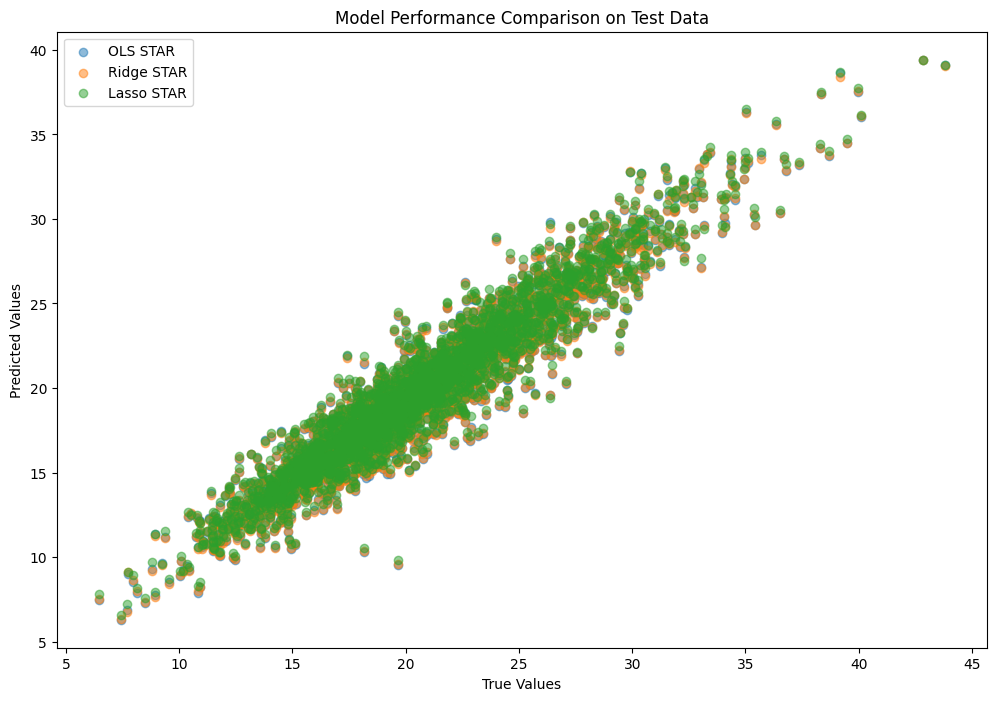

In [33]:
compare_all_models_test(df_test_all, target_variable)
    